In [56]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import operator
import nltk
from nltk.corpus import stopwords
import string 

YSNO_MAP = set(['is', 'can', 'does', 'are', 'do', 'should', 'did', 'will', 'was', 'has', 'could', 'were', 'would'])
CATEGORIES=set(["Automotive", "Baby", "Beauty", "Cell_Phones_and_Accessories",
                "Clothing_Shoes_and_Jewelry", "Electronics", "Grocery_and_Gourmet_Food",
                "Health_and_Personal_Care", "Home_and_Kitchen", "Musical_Instruments", 
                "Office_Products", "Patio_Lawn_and_Garden", "Pet_Supplies", 
                "Sports_and_Outdoors", "Tools_and_Home_Improvement", "Toys_and_Games", "Video_Games"])


In [2]:
def getDF(path):
    i = 0
    df = {}
    with open(path, 'r') as fp:
        for line in fp:
            df[i] = json.loads(line)
            i += 1
    
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
def general_stats_data(df):
    query_type_label = {'YESNO': 0, 'DESCRIPTION':0}
    wfa = 0
    total_judgements = 0
    total_wfa_judgments = 0
    multiple_answers = 0
    multiple_wfa = 0
    total_size = len(df)
    for row in df.iterrows():
        category = row[1]['query_type']
        total_judgements += len(row[1]['answers'])
        currentwfa = row[1]['wellFormedAnswers']
        if category in query_type_label:
            query_type_label[category] += 1
        else:
            print(category)
        if len(row[1]['answers']) > 1:
            multiple_answers += 1
        if currentwfa != '[]':
            wfa += 1
            total_wfa_judgments += len(currentwfa)
            if len(currentwfa) > 1:
                multiple_wfa += 1
    print('Columns:{}'.format(df.columns.values))
    print('{} queries with {} judgements with {} queries contain more than one judgment'.format(total_size,total_judgements,multiple_answers))
    #print('{} queries with Well Formed Answers of which {} contain more than one judgment'.format(wfa,multiple_wfa))
    print('----query distribution by dataset type----')
    for key in query_type_label:
        print(key + ',' + str(query_type_label[key])+ ',' + str(query_type_label[key]/total_size))

In [4]:
def update_query_type(query, query_type, qmap):
    assert len(query) > 0
    query = query.lower()
    head = query.split()[0]
    if query_type == "YESNO":
        qmap['yesno'] += 1
    elif head in qmap:
        qmap[head] += 1
    else:
        qmap['other'] +=1

In [5]:
def compute_query_word_stat(df):
    print('----query distribution by wording----')
    query_type_map = {'yesno':0, 'what':0, 'who':0, 'which':0, 'where':0, 'when':0, 'why':0, 'how':0, 'other':0}
    for row in df.iterrows():
        query = row[1]["query"]
        query_type = row[1]["query_type"]
        update_query_type(query, query_type, query_type_map)
    total = sum(list(query_type_map.values()))
    print(total)
    for k, v in query_type_map.items():
        print('{},{},{}'.format(k, v, 1.0 * v/total))

In [21]:
def get_stats(histogram):
    average = 0.0
    total_values = 0.0
    for value in histogram:
        total_values += histogram[value]
        average += float(histogram[value]) * float(value)
    return average/total_values

In [18]:
def generate_histograms(histogram, title):
    average = get_stats(histogram)
    print("###################################\n")
    print("Statistics about {}\n".format(title))
    print("Average length:{}",format(average))
    print("###################################\n")
    plt.bar(list(histogram.keys()), histogram.values(), color='g')
    plt.show()
    #for key in sorted(histogram.keys()):
    #   print("{}:{}".format(key, histogram[key]))

In [8]:
def compute_length_stat(df):
    queries = {}
    answers = {}
    well_formed_answers = {}
    passages = {}

    for row in df.iterrows():
        queries[row[1]['query']] = 1
        for v in row[1]['answers']:
            answers[v] = 1
        for p in row[1]['passages']:
            passages[p['passage_text']] = 1
    data = {'queries' : queries, 'answers' : answers, 'passages' : passages}
    for value in data:
        histogram = {}
        for v in data[value]:
            l = len(v.split())
            if l in histogram:
                histogram[l] += 1
            else:
                histogram[l] = 1
        generate_histograms(histogram, value)

# Load data

In [2]:
data_dir = "/Users/rchanda/Acads/Fall-2018/Capstone/Explicable-Question-Answering/data/"

In [10]:
train_infile = data_dir+"train-qar_msmarco_all.jsonl"
train_df = getDF(train_infile)

In [10]:
val_infile = data_dir+"val-qar_msmarco_all.jsonl"
val_df = getDF(val_infile)

test_infile = data_dir+"test-qar_msmarco_all.jsonl"
test_df = getDF(test_infile)

# General Stats

In [11]:
general_stats_data(train_df)

Columns:['answers' 'passages' 'query' 'query_id' 'query_type' 'wellFormedAnswers']
668243 queries with 2635677 judgements with 663767 queries contain more than one judgment
----query distribution by dataset type----
YESNO,98789,0.14783394663318583
DESCRIPTION,569454,0.8521660533668142


In [11]:
general_stats_data(val_df)

Columns:['answers' 'passages' 'query' 'query_id' 'query_type' 'wellFormedAnswers']
83429 queries with 330238 judgements with 82857 queries contain more than one judgment
----query distribution by dataset type----
YESNO,12148,0.14560884105047406
DESCRIPTION,71281,0.854391158949526


In [12]:
general_stats_data(test_df)

Columns:['answers' 'passages' 'query' 'query_id' 'query_type' 'wellFormedAnswers']
83408 queries with 328671 judgements with 82834 queries contain more than one judgment
----query distribution by dataset type----
YESNO,12477,0.14958996738921926
DESCRIPTION,70931,0.8504100326107807


# Query Stats

In [12]:
compute_query_word_stat(train_df)

----query distribution by wording----
668243
yesno,98789,0.14783394663318583
what,62880,0.09409750644600841
who,376,0.0005626695678069205
which,2262,0.00338499617654057
where,7916,0.011845990156275486
when,2478,0.0037082318857062477
why,4230,0.006330032637827856
how,60352,0.09031445147947678
other,428960,0.6419221750171719


In [13]:
compute_query_word_stat(val_df)

----query distribution by wording----
83429
yesno,12148,0.14560884105047406
what,7887,0.09453547327667837
who,35,0.00041951839288496807
which,279,0.003344160903283031
where,1043,0.012501648107972049
when,311,0.003727720576777859
why,495,0.00593318869937312
how,7547,0.09046015174579583
other,53684,0.6434692972467607


In [14]:
compute_query_word_stat(test_df)

----query distribution by wording----
83408
yesno,12477,0.14958996738921926
what,7896,0.09466717820832533
who,40,0.00047957030500671397
which,302,0.0036207558028006907
where,1000,0.01198925762516785
when,308,0.0036926913485516976
why,527,0.006318338768463457
how,7315,0.08770141952810281
other,53543,0.6419408210243621


# Length Statistics

###################################

Statistics about queries

Average length:{} 14.825549171909616
###################################



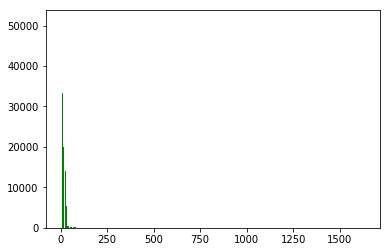

###################################

Statistics about answers

Average length:{} 31.284618669260194
###################################



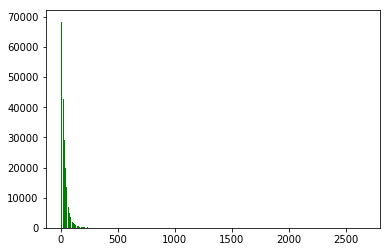

###################################

Statistics about passages

Average length:{} 72.03875690776935
###################################



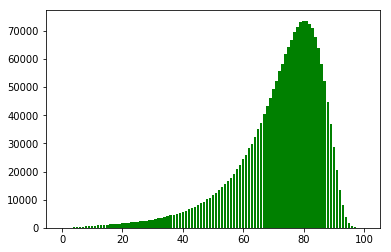

In [13]:
compute_length_stat(train_df)

###################################

Statistics about queries

Average length:{} 14.565507724909445
###################################



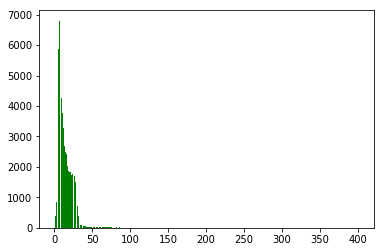

###################################

Statistics about answers

Average length:{} 30.846212184487914
###################################



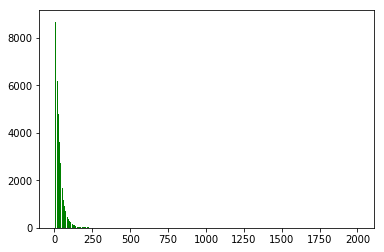

###################################

Statistics about passages

Average length:{} 72.05204675490509
###################################



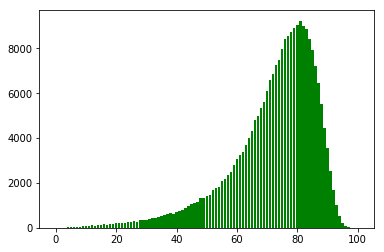

In [15]:
compute_length_stat(val_df)

###################################

Statistics about queries

Average length:{} 14.556469689878563
###################################



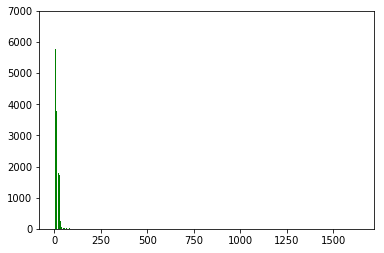

###################################

Statistics about answers

Average length:{} 30.655554363927635
###################################



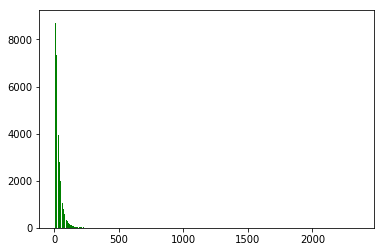

###################################

Statistics about passages

Average length:{} 72.02502122155302
###################################



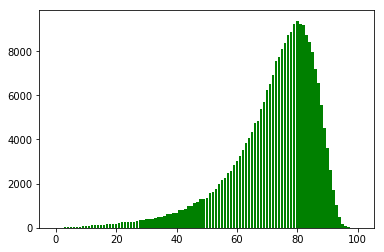

In [16]:
compute_length_stat(test_df)

# Category Analysis

In [3]:
def compute_category_stats(df):
    stats_map = {}
    for cat in CATEGORIES:
        stats_map[cat] = {"#products":set(), "#questions":0, "#answers":0, "#review_snippets": 0}
    
    for row in df.iterrows():
        row = row[1]
        if "category" not in row:
            print(row)
            exit(0)
        cat = row["category"]
        stats_map[cat]["#products"].add(row["asin"])
        stats_map[cat]["#questions"] += 1
        stats_map[cat]["#answers"] += len(row["answers"])
        stats_map[cat]["#review_snippets"] += len(row["review_snippets"])
    
    print("category                  #products #questions #answers #review_snippets")
    for cat in CATEGORIES:
        print("-------------------------------------")
        print("%s %d %d %d %d" % (cat, len(stats_map[cat]["#products"]), 
                                  stats_map[cat]["#questions"], 
                                  stats_map[cat]["#answers"], 
                                  stats_map[cat]["#review_snippets"]))
    print("-------------------------------------\n")

# Load Data

In [4]:
data_dir = "/Users/rchanda/Acads/Fall-2018/Capstone/Explicable-Question-Answering/data/"

In [5]:
train_infile = data_dir+"train-qar_all.jsonl"
train_df = getDF(train_infile)

In [5]:
val_infile = data_dir+"val-qar_all.jsonl"
val_df = getDF(val_infile)

test_infile = data_dir+"test-qar_all.jsonl"
test_df = getDF(test_infile)

# General Count Analysis

In [6]:
compute_category_stats(train_df)

category                  #products #questions #answers #review_snippets
-------------------------------------
Office_Products 3757 23441 90696 181005
-------------------------------------
Beauty 3800 21743 83109 169975
-------------------------------------
Electronics 26211 158555 595632 1316339
-------------------------------------
Toys_and_Games 4958 27908 107434 206599
-------------------------------------
Baby 2284 13659 51153 117185
-------------------------------------
Cell_Phones_and_Accessories 6349 38371 149547 302041
-------------------------------------
Patio_Lawn_and_Garden 5284 33333 137211 244085
-------------------------------------
Home_and_Kitchen 15415 97110 401715 742245
-------------------------------------
Musical_Instruments 2173 13476 50717 108161
-------------------------------------
Health_and_Personal_Care 7226 43618 174383 348020
-------------------------------------
Pet_Supplies 3057 20187 87369 167806
-------------------------------------
Tools_and_Home_Im

In [6]:
compute_category_stats(val_df)

category                  #products #questions #answers #review_snippets
-------------------------------------
Tools_and_Home_Improvement 1142 7223 29522 52633
-------------------------------------
Video_Games 125 823 3140 7725
-------------------------------------
Electronics 3288 19725 74299 161916
-------------------------------------
Grocery_and_Gourmet_Food 267 1418 5746 10526
-------------------------------------
Health_and_Personal_Care 896 5426 21984 42492
-------------------------------------
Home_and_Kitchen 1882 12165 50452 92631
-------------------------------------
Cell_Phones_and_Accessories 777 4675 18246 36426
-------------------------------------
Beauty 488 2846 11194 22404
-------------------------------------
Patio_Lawn_and_Garden 635 3994 16264 28676
-------------------------------------
Musical_Instruments 264 1615 5980 13032
-------------------------------------
Office_Products 457 2913 11160 22390
-------------------------------------
Pet_Supplies 394 2636 11579 

In [7]:
compute_category_stats(test_df)

category                  #products #questions #answers #review_snippets
-------------------------------------
Tools_and_Home_Improvement 1115 7059 28338 51466
-------------------------------------
Video_Games 123 750 2745 7024
-------------------------------------
Electronics 3282 19796 74407 162889
-------------------------------------
Grocery_and_Gourmet_Food 251 1309 5373 9658
-------------------------------------
Health_and_Personal_Care 899 5473 21766 45522
-------------------------------------
Home_and_Kitchen 1913 12002 49840 91917
-------------------------------------
Cell_Phones_and_Accessories 801 4972 19657 39617
-------------------------------------
Beauty 451 2595 9873 20223
-------------------------------------
Patio_Lawn_and_Garden 619 3782 15524 27828
-------------------------------------
Musical_Instruments 235 1442 5449 11712
-------------------------------------
Office_Products 490 3048 11551 23946
-------------------------------------
Pet_Supplies 404 2626 11150 21

# Full Category Analysis

In [4]:
def compute_full_category_stats(df, cat):
    stats_map = {}
    stats_map[cat] = {"#products":set(), "#questions":0, "#answers":0, "#reviews": 0}
    
    for row in df.iterrows():
        row = row[1]
        stats_map[cat]["#products"].add(row["asin"])
        for question in row["questions"]:
            stats_map[cat]["#questions"] += 1
            stats_map[cat]["#answers"] += len(question["answers"])
        stats_map[cat]["#reviews"] += len(row["reviews"])
    
    print("category                  #products #questions #answers #reviews")
    print("-------------------------------------")
    print("%s %d %d %d %d" % (cat, len(stats_map[cat]["#products"]), 
                              stats_map[cat]["#questions"], 
                              stats_map[cat]["#answers"], 
                              stats_map[cat]["#reviews"]))
    print("-------------------------------------\n")

In [5]:
for cat in CATEGORIES:
    infile = data_dir+"qar_products_"+cat+".jsonl"
    df = getDF(infile)
    compute_full_category_stats(df, cat)

category                  #products #questions #answers #reviews
-------------------------------------
Office_Products 5409 32567 124690 465165
-------------------------------------

category                  #products #questions #answers #reviews
-------------------------------------
Baby 3101 18102 67354 359915
-------------------------------------

category                  #products #questions #answers #reviews
-------------------------------------
Tools_and_Home_Improvement 12856 78693 315601 751241
-------------------------------------

category                  #products #questions #answers #reviews
-------------------------------------
Clothing_Shoes_and_Jewelry 1262 7016 27435 92970
-------------------------------------

category                  #products #questions #answers #reviews
-------------------------------------
Sports_and_Outdoors 14866 88949 351238 988820
-------------------------------------

category                  #products #questions #answers #reviews
-------

In [1]:
# Utils

In [11]:
def convert(infile, outfile):
    rfp = open(infile, 'r')
    wfp = open(outfile, 'w')
    
    for line in rfp:
        final_json = json.loads(line)
        if len(final_json["context"].split(' ')) == 0:
            continue
        wfp.write(line)
    wfp.close()

In [12]:
data_dir = "/Users/rchanda/Acads/Fall-2018/Capstone/Explicable-Question-Answering/data/old/"
infile = data_dir+"val-qar_squad_all.jsonl"
outfile = data_dir+"val-qar_squad_all.jsonl_new"
convert(infile, outfile)

# Span Analysis

In [102]:
def process_text(text):
    punctuations = string.punctuation.replace("\'", '')

    for ch in punctuations:
        text1 = text.replace(ch, "")

    tokens = text1.split()
    
    for i, token in enumerate(tokens):
        if not token.isupper():
            tokens[i] = token.lower()
    return ' '.join(tokens)

In [103]:
def get_all_spans(input_file):
    all_spans = []

    rfp = open(input_file, 'r')
    for line in tqdm(rfp):
        row = json.loads(line)
        spans = row["qas"][0]["answers"]
        for span in spans:
            text = process_text(span["text"])
            all_spans.append(text)
    
    return all_spans

In [104]:
data_dir = "/Users/rchanda/Acads/Fall-2018/Capstone/Explicable-Question-Answering/data/"
input_file = data_dir+"val-qar_squad_all.jsonl"

In [ ]:
all_spans = get_all_spans(input_file)

In [106]:
def get_span_stats(all_spans):
    word_freqs = defaultdict(int)
    span_lens = defaultdict(int)
    span_freqs = defaultdict(int)
    
    for text in all_spans:
        span_freqs[text] += 1
        
        tokens = text.split()
        span_lens[len(tokens)] += 1
        for word in tokens:
            word_freqs[word] += 1
    
    generate_histograms(span_lens, "span_lens")
    return word_freqs, span_freqs

###################################

Statistics about span_lens

Average length:{} 6.2478289592216685
###################################



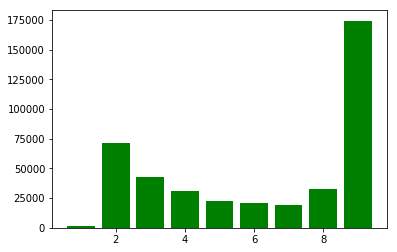

In [107]:
word_freqs, span_freqs = get_span_stats(all_spans)

In [108]:
sorted_word_freqs = sorted(word_freqs.items(), key=operator.itemgetter(1), reverse=True)

In [109]:
sorted_word_freqs[:50]

[('the', 240276),
 ('I', 107712),
 ('to', 93570),
 ('a', 91138),
 ('it', 86713),
 ('and', 86164),
 ('is', 70213),
 ('of', 55509),
 ('have', 42627),
 ('for', 39892),
 ('in', 39834),
 ('on', 38058),
 ('this', 37317),
 ('with', 33115),
 ('that', 28540),
 ('my', 28428),
 ('you', 25815),
 ('not', 22937),
 ('but', 19307),
 ('was', 16972),
 ('are', 15530),
 ('use', 14735),
 ('be', 13378),
 ('as', 12736),
 ('so', 10851),
 ('can', 10705),
 ('if', 10544),
 ('they', 10225),
 ('had', 9735),
 ('one', 9262),
 ('would', 9072),
 ('very', 8908),
 ('get', 7264),
 ('will', 7252),
 ('bought', 7067),
 ('at', 6916),
 ('has', 6842),
 ('used', 6684),
 ('out', 6638),
 ('from', 6284),
 ("don't", 6196),
 ('just', 6158),
 ('up', 6122),
 ('when', 6089),
 ('like', 6023),
 ('these', 5627),
 ('all', 5486),
 ('do', 5320),
 ('an', 5204),
 ('am', 4999)]

In [110]:
sorted_span_freqs = sorted(span_freqs.items(), key=operator.itemgetter(1), reverse=True)

In [111]:
sorted_span_freqs[:100]

[('of the', 2292),
 ('it is', 1952),
 ('I have', 1936),
 ('in the', 1920),
 ('on the', 1697),
 ('is a', 1439),
 ('with the', 945),
 ('to the', 941),
 ('and the', 888),
 ('for the', 833),
 ('and it', 811),
 ('with a', 581),
 ('for a', 533),
 ('they are', 512),
 ('and I', 485),
 ('this is', 444),
 ('have a', 434),
 ('I bought', 426),
 ('if you', 412),
 ('to be', 406),
 ('is the', 377),
 ('you can', 376),
 ('I am', 376),
 ('it was', 366),
 ('I have a', 362),
 ("I don't", 361),
 ('but I', 337),
 ('it is a', 323),
 ('for my', 317),
 ('in a', 310),
 ('have to', 310),
 ('I was', 301),
 ('I would', 299),
 ('but it', 277),
 ('it to', 234),
 ('this is a', 232),
 ('has a', 230),
 ('I had', 229),
 ('is not', 228),
 ('to use', 214),
 ('it does', 209),
 ('so I', 189),
 ('on my', 187),
 ('from the', 183),
 ('that I', 181),
 ('and it is', 177),
 ('as a', 174),
 ('it will', 169),
 ('at the', 169),
 ('a little', 169),
 ('that it', 166),
 ('I use', 166),
 ('in my', 166),
 ('it has', 165),
 ('to get', 165